# **Laboratorijska vježba 7**: Zadaci za samostalni rad

## **Predviđanje udomljavanja životinja**

U ovoj laboratorijskoj vježbi istražit ćemo skup podataka koji sadrži podatke o životinjama iz skloništa za životinje. Cilj je izgraditi i trenirati algoritam strojnog učenja koji će predvidjeti hoće li životinja iz skloništa biti udomljena ili ne. Skup podataka sadrži sljedeće značajke:

- animal_type - tip životinje
- intake_year - godina primanja u sklonište
- intake_condition - stanje životinje pri primanju u sklonište
- intake_number - broj slučajeva kada je ista životinja dovedena u sklonište
- intake_type - tip donošenja u sklonište (primjerice, zalutala životinja, dobrovoljna predaja vlasnika,...)
- sex_upon_intake - spol životinje i informacija o kastriranju pri primanju
- age_upon_intake - dob životinje pri primanju
- time_in_shelter_days - broj dana koja je životinja provela u skloništu
- sex_upon_outcome - spol životinje i informacija o kastriranju pri donošenju odluke o udomljavanju
- age_upon_outcome - dob životinje pri donošenju odluke o udomljavanju
- outcome_type - odluka o udomljavanju


In [214]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sn
%matplotlib inline

data_folder = './Data/'

In [215]:
data = pd.read_csv(data_folder + "aac_intakes_outcomes.csv")
data = data.head(5000)
# Skup podataka smanjen na 5000 zbog predugog vremena izvrsavanja odredenih dijelova koda

## **Zadatak 1: Transformacija značajki**

Uredite skup podataka na način da rukujete s nedostajućim vrijednostima. Provjerite ima li takvih vrijednosti te ih uklonite ili nadomjestite prikladnim vrijednostima.


In [216]:
cols = [
    "animal_type",
    "intake_year",
    "intake_condition",
    "intake_number",
    "intake_type",
    "sex_upon_intake",
    "age_upon_intake",
    "time_in_shelter_days",
    "sex_upon_outcome",
    "age_upon_outcome",
    "outcome_type",
]
data = data[cols]
data.dropna(inplace=True)
data.isna().sum()


animal_type             0
intake_year             0
intake_condition        0
intake_number           0
intake_type             0
sex_upon_intake         0
age_upon_intake         0
time_in_shelter_days    0
sex_upon_outcome        0
age_upon_outcome        0
outcome_type            0
dtype: int64

In [217]:
data.head()

,animal_type,intake_year,intake_condition,intake_number,intake_type,sex_upon_intake,age_upon_intake,time_in_shelter_days,sex_upon_outcome,age_upon_outcome,outcome_type
0,Dog,2017,Normal,1.0,Stray,Neutered Male,10 years,0.588194,Neutered Male,10 years,Return to Owner
1,Dog,2014,Normal,2.0,Public Assist,Neutered Male,7 years,1.259722,Neutered Male,7 years,Return to Owner
2,Dog,2014,Normal,3.0,Public Assist,Neutered Male,6 years,1.113889,Neutered Male,6 years,Return to Owner
3,Dog,2014,Normal,1.0,Owner Surrender,Neutered Male,10 years,4.970139,Neutered Male,10 years,Transfer
4,Dog,2013,Injured,1.0,Public Assist,Neutered Male,16 years,0.119444,Neutered Male,16 years,Return to Owner


Prebacite kategoričke i ordinalne značajke u numeričke pomoću _one-hot encoding_ tehnike.


In [218]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = [
    "animal_type",
    "intake_condition",
    "intake_type",
    "sex_upon_intake",
    "sex_upon_outcome",
]

ohe = OneHotEncoder()

for category in categorical_columns:
    new = ohe.fit_transform(data[[category]])
    data[ohe.categories_[0]] = new.toarray()
    data = data.drop([category], axis=1)


In [219]:
data.head()


,intake_year,intake_number,age_upon_intake,time_in_shelter_days,age_upon_outcome,outcome_type,Cat,Dog,Other,Aged,...,Euthanasia Request,Owner Surrender,Public Assist,Stray,Wildlife,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
0,2017,1.0,10 years,0.588194,10 years,Return to Owner,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2014,2.0,7 years,1.259722,7 years,Return to Owner,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2014,3.0,6 years,1.113889,6 years,Return to Owner,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2014,1.0,10 years,4.970139,10 years,Transfer,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2013,1.0,16 years,0.119444,16 years,Return to Owner,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [220]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data["outcome_type"] = le.fit_transform(data["outcome_type"])
y = data["outcome_type"]
y = y.values
data = data.drop(["outcome_type"], axis=1)

age_cols = ["age_upon_intake", "age_upon_outcome"]

# Uklanja upozorenja za kod koji slijedi
pd.options.mode.chained_assignment = None  # default='warn'

for col in age_cols:
    data[col] = data[col].replace(" years", "", regex=True)
    data[col][data[col].str.contains(" ") == True] = 1
    data[col] = data[col].astype(int)

data.head()


,intake_year,intake_number,age_upon_intake,time_in_shelter_days,age_upon_outcome,Cat,Dog,Other,Aged,Feral,...,Euthanasia Request,Owner Surrender,Public Assist,Stray,Wildlife,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
0,2017,1.0,10,0.588194,10,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2014,2.0,7,1.259722,7,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2014,3.0,6,1.113889,6,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2014,1.0,10,4.970139,10,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2013,1.0,16,0.119444,16,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Normalizirajte vrijednosti svih značajki u interval $[0,1]$.


In [221]:
from sklearn.preprocessing import MinMaxScaler

data.drop
data = data.astype(float)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
l = []
for col in data.columns:
    l.append(col)
data_scaled = pd.DataFrame(scaled, columns=l)
data_scaled


,intake_year,intake_number,age_upon_intake,time_in_shelter_days,age_upon_outcome,Cat,Dog,Other,Aged,Feral,...,Euthanasia Request,Owner Surrender,Public Assist,Stray,Wildlife,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
0,0.8,0.000000,0.50,0.000468,0.473684,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.2,0.142857,0.35,0.001003,0.315789,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.2,0.285714,0.30,0.000887,0.263158,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.2,0.000000,0.50,0.003960,0.473684,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.000000,0.80,0.000095,0.789474,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.000000,0.05,0.003862,0.000000,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4996,0.0,0.000000,0.05,0.000055,0.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4997,0.0,0.000000,0.05,0.005424,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4998,0.0,0.000000,0.10,0.000053,0.052632,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [222]:
l

['intake_year',
 'intake_number',
 'age_upon_intake',
 'time_in_shelter_days',
 'age_upon_outcome',
 'Cat',
 'Dog',
 'Other',
 'Aged',
 'Feral',
 'Injured',
 'Normal',
 'Nursing',
 'Pregnant',
 'Sick',
 'Euthanasia Request',
 'Owner Surrender',
 'Public Assist',
 'Stray',
 'Wildlife',
 'Intact Female',
 'Intact Male',
 'Neutered Male',
 'Spayed Female',
 'Unknown']

## **Zadatak 2: Odabir modela**

Za uređeni skup podataka provedite odabir modela. Prvo podijelite skup podataka na podskupove za treniranje i testiranje u omjeru 80:20. Zatim definirajte mrežu hiperparametara za četiri klasifikatora: DT, SVM, $k$-NN i logističku regresiju.


In [223]:
X = data_scaled[l]


In [224]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Na podskupu za treniranje isprobajte sve kombinacije hiperparametara te usporedite najbolje kombinacije za svaki klasifikator na podskupu za testiranje. Odaberite prikladnu mjeru za usporedbu performansi. Možete koristiti klasu GridSearchCV te podijeliti podskup za trening postupkom unakrsne provjere $5$ preklopa.


In [225]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# SVC params
kernel = ("linear", "rbf")
c = [1, 5, 10, 50]

# KNN params
n_neighbors = [1, 2, 3, 5, 7, 9]
weights = ("uniform", "distance")
algorithm = ("auto", "ball_tree", "kd_tree", "brute")

# DT params
criterion = ("gini", "entropy", "log_loss")
splitter = ("best", "random")
max_depth = [5, 10, 25, 50, 80]

# LR params
penalty = (None, "l1", "l2", "elasticnet")
fit_intercept = (True, False)

In [226]:
parameters = {"kernel": kernel, "C": c}
svc = SVC()

svc_grid = GridSearchCV(svc, parameters, scoring="accuracy", cv=5)
svc_grid.fit(X_train, y_train)
print("SVC: ")
print("Najbolji parametri: ", svc_grid.best_params_)
print("Accuracy score: ", accuracy_score(svc_grid.predict(X_test), y_test))


/Users/lukakuterovac/Documents/Programming/faculty/data-analysis-exercises/env/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


SVC: 
Najbolji parametri:  {'C': 50, 'kernel': 'rbf'}
Accuracy score:  0.676


In [227]:
parameters = {"n_neighbors": n_neighbors, "weights": weights, "algorithm": algorithm}
knn = KNeighborsClassifier()

knn_grid = GridSearchCV(knn, parameters, scoring="accuracy", cv=5)
knn_grid.fit(X_train, y_train)
print("KNN:")
print("Najbolji parametri", knn_grid.best_params_)
print("Accuracy score: ", accuracy_score(knn_grid.predict(X_test), y_test))


/Users/lukakuterovac/Documents/Programming/faculty/data-analysis-exercises/env/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


KNN:
Najbolji parametri {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
Accuracy score:  0.667


In [228]:
parameters = {
    "criterion": criterion,
    "splitter": splitter,
    "max_depth": max_depth,
}
dt = DecisionTreeClassifier()

dt_grid = GridSearchCV(dt, parameters, scoring="accuracy", cv=5)
dt_grid.fit(X_train, y_train)
print("DT:")
print("Najbolji parametri", dt_grid.best_params_)
print("Accuracy score: ", accuracy_score(dt_grid.predict(X_test), y_test))

/Users/lukakuterovac/Documents/Programming/faculty/data-analysis-exercises/env/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


DT:
Najbolji parametri {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
Accuracy score:  0.707


In [229]:
parameters = {
    "penalty": penalty,
    "fit_intercept": fit_intercept,
}
lr = LogisticRegression()

lr_grid = GridSearchCV(lr, parameters, scoring="accuracy", cv=5)
lr_grid.fit(X_train, y_train)
print("LR:")
print(lr_grid.best_params_)
print(lr_grid.score(X_test, y_test))

# Error : STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
# Kod izbaci rezultat ali nisam siguran kako rjesit error

/Users/lukakuterovac/Documents/Programming/faculty/data-analysis-exercises/env/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/lukakuterovac/Documents/Programming/faculty/data-analysis-exercises/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lukakuterovac/Documents/Programming/faculty/data-analysis-exercises/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarn

LR:
{'fit_intercept': False, 'penalty': None}
0.693


/Users/lukakuterovac/Documents/Programming/faculty/data-analysis-exercises/env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lukakuterovac/Documents/Programming/faculty/data-analysis-exercises/env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lukakuterovac/Documents/Programming/faculty/data-analysis-exercises/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver

Prokomentirajte dobivene rezultate. Koji klasifikator ima najbolje performanse?


## **Zadatak 3: Odabir značajki - filtri**


Podijelite uređeni skup podataka na podskupove za treniranje i testiranje u omjeru 80:20 (koristite isto stanje nasumičnosti kao i u Zadatku 2).


In [230]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Pomoću proizvoljnog filtra provedite odabir značajki za promatrani skup podataka. Rangirajte sve značajki na temelju vrijednosti mjere unutar filtra te iscrtajte stupčasti dijagram tih vrijednosti.


Odaabrane značajke: 
['time_in_shelter_days' 'Owner Surrender']


<BarContainer object of 25 artists>

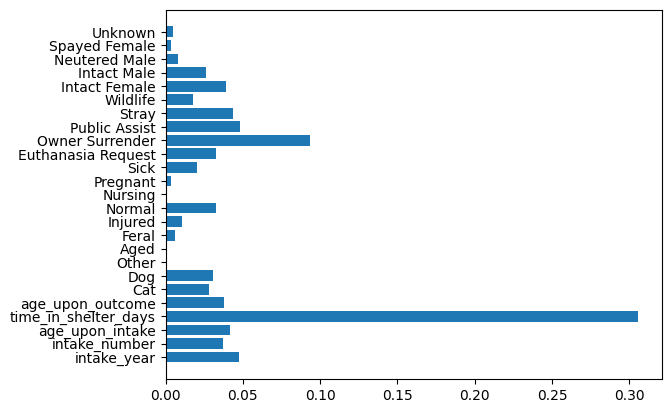

In [231]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

skb = SelectKBest(mutual_info_classif, k=2)
X_new = skb.fit_transform(X, y)

print("Odaabrane značajke: ")
print(skb.get_feature_names_out())
scores = skb.scores_

dt = DecisionTreeClassifier(criterion="gini", max_depth=10, splitter="best").fit(
    X_new, y
)

l = []
for col in X.columns:
    l.append(col)
plt.barh(l, scores)


Odaberite $K$ najbolje rangiranih značajki te trenirajte klasifikatore na podskupu za treniranje koristeći odabrane značajke. Možete koristiti najbolje klasifikatore iz Zadatka 2. Samostalno odaberite prikladnu vrijednost za $K$. Usporedite performanse ovih klasifikatora na podskupu za testiranje prije i nakon odabira značajki.


In [232]:
dt = DecisionTreeClassifier(criterion="gini", max_depth=10, splitter="best").fit(
    X_train, y_train
)
print("Prije FS: ", accuracy_score(y_test, dt.predict(X_test)))

skb = SelectKBest(mutual_info_classif, k=17)

X_new = skb.fit_transform(X_train, y_train)
X_test_new = skb.transform(X_test)

print("Odabrane značajke: ")
print(skb.get_feature_names_out())

dt = DecisionTreeClassifier(criterion="gini", max_depth=10, splitter="best").fit(
    X_new, y_train
)
print("Nakon FS: ", accuracy_score(y_test, dt.predict(X_test_new)))

Prije FS:  0.705
Odabrane značajke: 
['intake_year' 'intake_number' 'age_upon_intake' 'time_in_shelter_days'
 'age_upon_outcome' 'Cat' 'Dog' 'Injured' 'Normal' 'Nursing'
 'Euthanasia Request' 'Owner Surrender' 'Public Assist' 'Stray' 'Wildlife'
 'Intact Female' 'Intact Male']
Nakon FS:  0.7


## **Zadatak 4: Odabir značajki - omotači**


Podijelite uređeni skup podataka na podskupove za treniranje i testiranje u omjeru 80:20 (koristite isto stanje nasumičnosti kao i u Zadatku 2). Zatim dodatno podijelite podskup za treniranje na podskupove za treniranje i vrednovanje u omjeru 65:35.


In [233]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [234]:
X_train_1, X_val, y_train_1, y_val = train_test_split(
    X_train, y_train, test_size=0.35, random_state=42
)


Pomoću omotača SFS provedite odabir značajki za promatrani skup podataka. Isprobajte nekoliko različitih vrijednosti za konačan broj značajki, vodeći se performansama klasifikatora. Možete koristiti najbolji klasifikator iz Zadatka 2 za vrednovanje podskupova značajki. Napomena: klasifikator trenirajte na podskupu za trening, a podskupove značajki koje stvara SFS vrednujte na podskupu za vrednovanje.


In [235]:
from sklearn.feature_selection import SequentialFeatureSelector

dt = DecisionTreeClassifier(criterion="gini", max_depth=10, splitter="best").fit(
    X_train, y_train
)
sfs = SequentialFeatureSelector(
    dt,
    n_features_to_select=16,
    direction="forward",
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
)
sfs.fit(X_val, y_val)
np.arange(X.shape[1])[sfs.support_]  # indeksi odabranih parametara


/Users/lukakuterovac/Documents/Programming/faculty/data-analysis-exercises/env/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/lukakuterovac/Documents/Programming/faculty/data-analysis-exercises/env/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/lukakuterovac/Documents/Programming/faculty/data-analysis-exercises/env/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/lukakuterovac/Documents/Programming/faculty/data-analysis-exercises/env/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is les

array([ 1,  3,  5,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 24])

Najbolje klasifikatore iz Zadatka 2 trenirajte na objedinjenom podskupu za treniranje i vrednovanje, koristeći odabrane značajke iz ovog zadatka. Usporedite performanse ovih klasifikatora na podskupu za testiranje prije i nakon odabira značajki.


In [236]:
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)
dt.fit(X_train_sfs, y_train)
y_pred_sfs = dt.predict(X_test_sfs)
sfs_score = accuracy_score(y_test, y_pred_sfs)

dt = DecisionTreeClassifier(criterion="gini", max_depth=10, splitter="best")
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
score = accuracy_score(y_test, y_pred)

print("Sa sfs-om", sfs_score)
print("Bez sfs-a", score)


Sa sfs-om 0.709
Bez sfs-a 0.708


## **Zadatak 5: Preuzorkovanje**

Podijelite uređeni skup podataka na podskupove za treniranje i testiranje u omjeru 80:20 (koristite isto stanje nasumičnosti kao i u Zadatku 2).


In [237]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Pomoću metode nasumičnog preuzorkovanja provedite preuzorkovanje podskupa za treniranje.


In [238]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy="minority")
X_new, y_new = oversample.fit_resample(X_train, y_train)

Najbolje klasifikatore iz Zadatka 2 trenirajte na preuzorkovanom podskupu za treniranje. Usporedite performanse ovih klasifikatora na podskupu za testiranje prije i nakon preuzorkovanja.


In [213]:
dt = DecisionTreeClassifier(criterion="gini", max_depth=10, splitter="best").fit(
    X_train, y_train
)
y_pred = dt.predict(X_test)
print("Bez metode nasumicnog preuzorkovanja", accuracy_score(y_test, y_pred))

dt = DecisionTreeClassifier(criterion="gini", max_depth=10, splitter="best").fit(
    X_new, y_new
)
y_pred_post = dt.predict(X_test)
print("Metoda nasumicnog preuzorkovanja", accuracy_score(y_test, y_pred_post))


Bez metode nasumicnog preuzorkovanja 0.703
Metoda nasumicnog preuzorkovanja 0.724
